In [3]:
import ffn
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from get_tickers import get_tickers
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [4]:
start_date = '2024-09-01'
end_date = '2024-10-01'
file_name = f' Monthly_{start_date}_to_{end_date}.csv'

In [5]:
#getting a list of S&P100 stocks
stocks = pd.DataFrame(get_tickers())
tickers = stocks["Symbol"]


In [4]:
#Iterate through the sp100 list to see if there are any tickers that have "issues"
'''
for x in tickers:
    try:
        data = ffn.get(x, start = "2020-6-01")
    except Exception as e:
        print(f'There is a problem with {x} : {e}')
'''


In [6]:
#using the ffn library to pull data
data = ffn.get(tickers, start = start_date, end = end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [7]:
#take a look at the data pull
data.tail()
len(data)

20

In [8]:
#calculate the daily and annual returns of the initial data pull
returns_daily = data.to_log_returns().dropna()
returns_annual = returns_daily.mean()*250
#return the length of the daily and annual returns dataframes for verification
len(returns_daily), len(returns_annual)

(19, 100)

In [9]:
#sort by annual returns in decreasing from highest annual return to lowest.
sort = pd.DataFrame(returns_annual.sort_values(ascending=False))

In [10]:
#create a list of top 20 tickers by annual return
top_20=sort[0:20].index
print(top_20)

Index(['tsla', 'orcl', 'amd', 'intc', 'ge', 'cat', 'avgo', 'nvda', 'meta',
       'hd', 'bkng', 'crm', 'low', 'ibm', 'cvs', 'nke', 'de', 'pypl', 'dis',
       'blk'],
      dtype='object')


In [11]:
#create a new dataframe that has only the top 20 stocks
top_20_df = data[[column for column in top_20]]
top_20_df.head()

,tsla,orcl,amd,intc,ge,cat,avgo,nvda,meta,hd,bkng,crm,low,ibm,cvs,nke,de,pypl,dis,blk
Date,,,,,,,,,,,,,,,,,,,,
2024-09-03,210.600006,139.187027,136.940002,20.100000,163.967148,340.239990,152.289108,107.990761,511.272247,364.739990,3804.956299,247.671173,245.460007,201.279999,57.380001,81.320000,384.333649,72.000000,89.129997,881.215210
2024-09-04,219.410004,140.434219,140.869995,19.430000,166.113968,336.750000,153.614746,106.200912,512.251282,364.670013,3790.419922,247.291763,245.449997,204.110001,59.299999,81.019997,390.571625,72.610001,89.250000,881.274841
2024-09-05,230.169998,142.290054,139.440002,19.400000,163.607681,333.559998,152.319031,107.200829,516.367371,361.850006,3773.129883,245.734207,244.110001,202.589996,58.070000,80.830002,382.340668,72.029999,88.650002,871.482788
2024-09-06,210.729996,141.491837,134.350006,18.889999,160.991547,329.359985,136.550873,102.821205,499.793182,360.049988,3731.350098,243.587585,243.809998,200.740005,57.750000,80.629997,380.218140,68.889999,87.940002,861.819946
2024-09-09,216.270004,139.576157,138.149994,19.070000,165.105469,334.040009,140.358368,106.460892,504.308899,365.519989,3802.889893,245.374771,244.729996,203.529999,56.470001,79.489998,385.868225,69.349998,88.339996,877.940002


In [22]:
top_20_df.to_csv('top_20 ' +file_name)



In [ ]:
'''
def get_open_prices(csv, start, end):

    data = pd.read_csv(csv)
    tickers = data.columns[1:]
    prices_open = ffn.get(tickers, start = open_on_date, end = close_date )
    transposed = prices_open.T
    transposed.columns = ['Price']
    transposed.index.name = 'Stock'
    print(transposed)
    return transposed

get_open_prices(top_20_csv, start_date, end_date)
'''

In [12]:
#calculate the returns per the top_20 df
top_20_ret_daily = top_20_df.to_log_returns().dropna()
top_20_ret_ann = top_20_ret_daily.mean()*250

In [13]:
#view the annualized returns of the top 20 S&P100 stocks
top_20_ret_ann

tsla    2.854877
orcl    2.632684
amd     2.379095
intc    2.033908
ge      1.840214
cat     1.833726
avgo    1.639691
nvda    1.544403
meta    1.486917
hd      1.384159
bkng    1.337653
crm     1.315357
low     1.295147
ibm     1.234575
cvs     1.204373
nke     1.098421
de      1.083766
pypl    1.058253
dis     1.003019
blk     0.982160
dtype: float64

In [14]:
#calculate the daily and annual covariances
top_20_cov_daily = top_20_ret_daily.cov()
top_20_cov_annual = top_20_cov_daily*250 #250 trading days in a year.

In [15]:
# create empty lists to store returns, volatility, and weights of possible portfolios
port_returns = []
port_volatility = []
sharpe_ratio = []
stock_weights = []

In [16]:
####################################################
# set the number of portfolio combinations with    #
# the number of assets and portfolios as variables #
####################################################
num_assets = len(top_20)
num_portfolios = 50000

In [17]:
#set random seed
np.random.seed(42)

In [18]:
# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, top_20_ret_ann)
    volatility = np.sqrt(np.dot(weights.T, np.dot(top_20_cov_annual, weights)))
    sharpe = returns / volatility
    sharpe_ratio.append(sharpe)
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

In [19]:
# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

for counter,symbol in enumerate(top_20):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

In [20]:
#create the final dataframe with X number of portfolios randomized with different weights
sp_top_20 = pd.DataFrame(portfolio)

In [ ]:
sp_top_20.tail()

In [21]:
# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio']+ [stock+' Weight' for stock in top_20]

In [22]:
# reorder dataframe columns
final = sp_top_20[column_order]

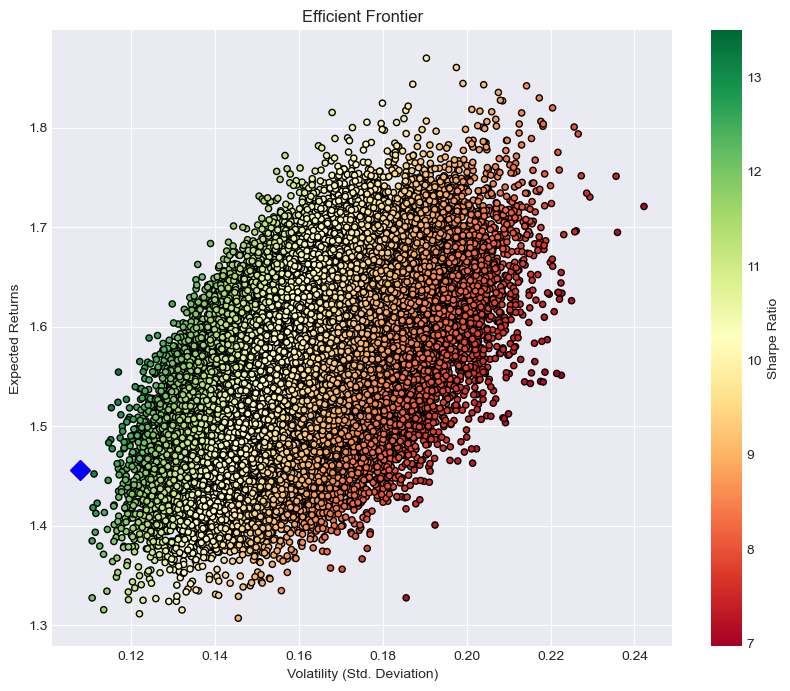

In [23]:
# find min Volatility & max sharpe values in the dataframe (df)
min_volatility = final['Volatility'].min()
max_sharpe = final['Sharpe Ratio'].max()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = final.loc[final['Sharpe Ratio'] == max_sharpe]
min_variance_port = final.loc[final['Volatility'] == min_volatility]

# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.available
plt.style.use('seaborn-v0_8-darkgrid')
final.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='D', s=100)
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='D', s=100 )
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [21]:
min_variance_port.T.as_format(".2%").to_csv('min_var '+file_name)

In [24]:
sharpe_portfolio.T.as_format(".2%").to_csv('max_sharpe ' + file_name)